## Clustering of Integrated scRNA-seq Data with SCVI and Leiden

In [1]:
# Importing libraries for single-cell RNA analysis
import scanpy as sc
import scvi

In [2]:
# Defining the base path to the directory containing single-cell RNA-seq data.
# Make sure to update this path according to your file system.
base_data_path = "/Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/data"


In [3]:
# Loading the AnnData object from the previously saved .h5ad file, which contains integrated data and analysis results.
adata = sc.read_h5ad(f'{base_data_path}/integrated_0.1.h5ad')


In [6]:
# Loading the pre-trained SCVI model from the specified directory and associating it with the AnnData object.
# Note: In the future, PyTorch's default for `weights_only` will change to improve security. 
# Ensure you trust the model file you are loading.
model = scvi.model.SCVI.load(f'{base_data_path}/model.model', adata)


INFO     File /Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/data/model.model/model.pt already downloaded          


/Users/klemkelab/PDAC_scRNAseq_PLAUR_GSE205013/.venv/lib/python3.12/site-packages/scvi/model/base/_save_load.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = tor

In [7]:
# Computing the UMAP (Uniform Manifold Approximation and Projection) for dimensionality reduction, 
# which helps visualize the structure of the data in 2D or 3D space based on the current embedding.
sc.tl.umap(adata)


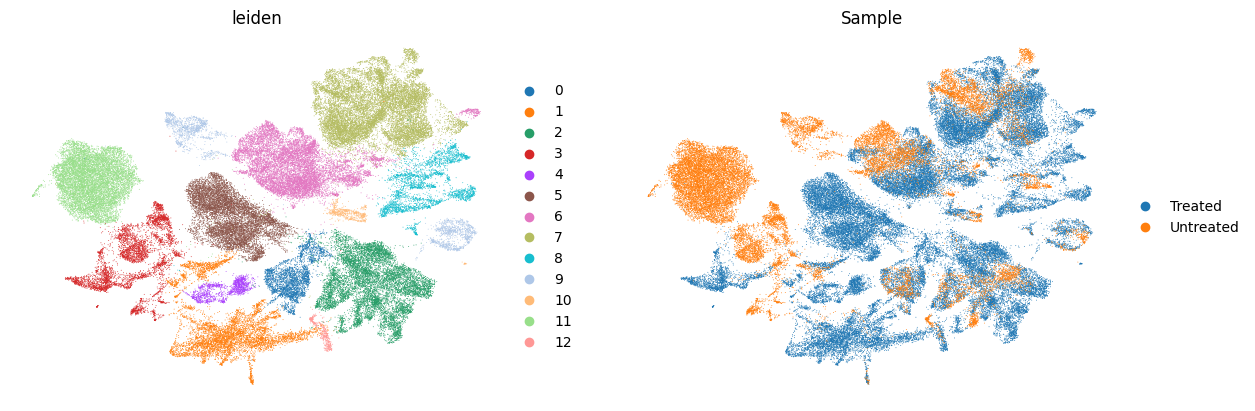

In [9]:
# Plotting the UMAP visualization, coloring cells based on 'leiden' clusters and 'Sample' metadata.
# The frame around the plot is turned off for a cleaner presentation.
sc.pl.umap(adata, color=['leiden', 'Sample'], frameon=False)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


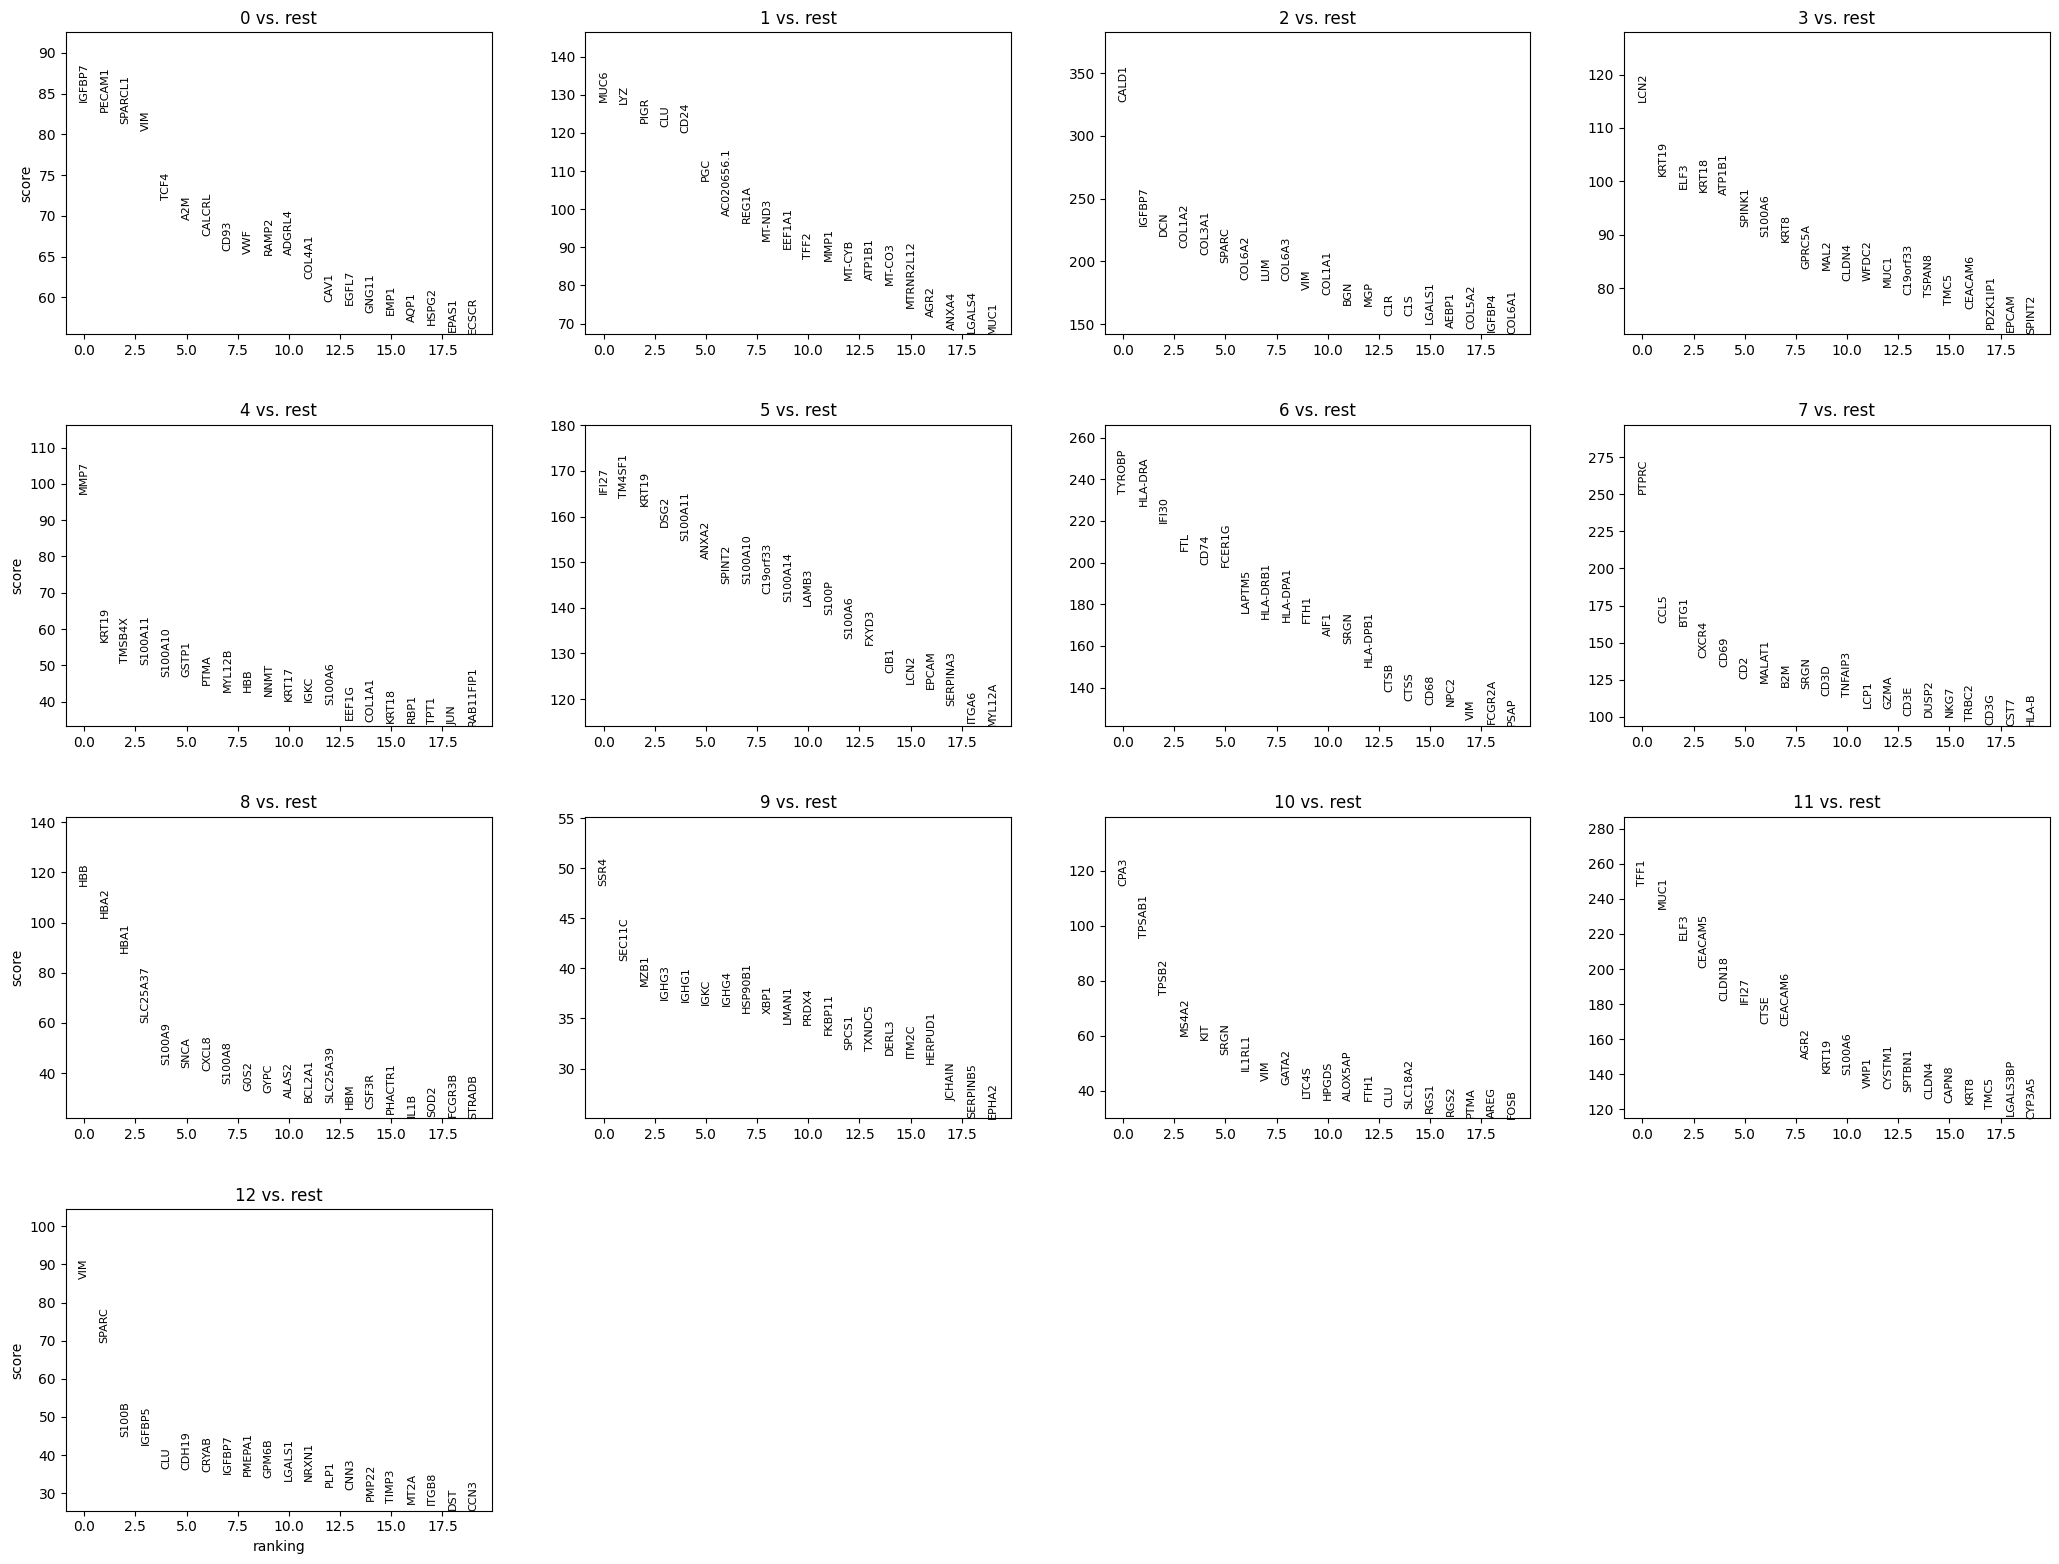

In [10]:
# Performing differential gene expression analysis to identify marker genes for each Leiden cluster.
# This ranks genes based on their expression levels across the different clusters.
sc.tl.rank_genes_groups(adata, 'leiden')

# Plotting the top 20 ranked marker genes for each Leiden cluster. 
# The 'sharey=False' argument allows each cluster's plot to have an independent y-axis for better visualization.
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)


In [11]:
# Extracting the ranked marker genes for all Leiden clusters into a DataFrame.
markers = sc.get.rank_genes_groups_df(adata, None)

# Filtering the markers to keep only those with adjusted p-values less than 0.05 (statistically significant)
# and log fold changes greater than 0.5 (indicating meaningful gene expression changes).
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > .5)]

# Displaying the filtered marker genes DataFrame.
markers


,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,IGFBP7,83.988060,4.128526,0.000000,0.000000
1,0,PECAM1,82.775070,5.648146,0.000000,0.000000
2,0,SPARCL1,81.332420,4.738361,0.000000,0.000000
3,0,VIM,80.459953,2.720602,0.000000,0.000000
4,0,TCF4,71.922195,4.136458,0.000000,0.000000
...,...,...,...,...,...,...
324341,12,BMS1P14,2.170022,1.459278,0.030551,0.049577
324343,12,TMEM222,2.168734,0.700999,0.030648,0.049731
324344,12,PRRT2,2.168149,1.151407,0.030694,0.049799
324345,12,LURAP1L-AS1,2.168052,4.091801,0.030704,0.049812


## Automated cell type annotation

In [13]:
# Importing the CellTypist library, which provides tools for automated cell type annotation in single-cell RNA-seq data.
# Also importing the 'models' module from CellTypist to load pre-trained cell type classification models.
import celltypist
from celltypist import models


In [14]:
# Downloading the latest pre-trained CellTypist models. 
# The 'force_update=True' ensures that the models are updated even if they were previously downloaded.
models.download_models(force_update=True)

# Displaying a description of all available CellTypist models, providing information about the cell types each model can classify.
models.models_description()


📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 52
📂 Storing models in /Users/klemkelab/.celltypist/data/models
💾 Downloading model [1/52]: Immune_All_Low.pkl
💾 Downloading model [2/52]: Immune_All_High.pkl
💾 Downloading model [3/52]: Adult_COVID19_PBMC.pkl
💾 Downloading model [4/52]: Adult_CynomolgusMacaque_Hippocampus.pkl
💾 Downloading model [5/52]: Adult_Human_MTG.pkl
💾 Downloading model [6/52]: Adult_Human_PancreaticIslet.pkl
💾 Downloading model [7/52]: Adult_Human_PrefrontalCortex.pkl
💾 Downloading model [8/52]: Adult_Human_Skin.pkl
💾 Downloading model [9/52]: Adult_Mouse_Gut.pkl
💾 Downloading model [10/52]: Adult_Mouse_OlfactoryBulb.pkl
💾 Downloading model [11/52]: Adult_Pig_Hippocampus.pkl
💾 Downloading model [12/52]: Adult_RhesusMacaque_Hippocampus.pkl
💾 Downloading model [13/52]: Autopsy_COVID19_Lung.pkl
💾 Downloading model [14/52]: COVID19_HumanChallenge_Blood.pkl
💾 Downloading model [15/52]: COVID19_Immune_La

,model,description
0,Immune_All_Low.pkl,immune sub-populations combined from 20 tissue...
1,Immune_All_High.pkl,immune populations combined from 20 tissues of...
2,Adult_COVID19_PBMC.pkl,peripheral blood mononuclear cell types from C...
3,Adult_CynomolgusMacaque_Hippocampus.pkl,cell types from the hippocampus of adult cynom...
4,Adult_Human_MTG.pkl,cell types and subtypes (10x-based) from the a...
5,Adult_Human_PancreaticIslet.pkl,cell types from pancreatic islets of healthy a...
6,Adult_Human_PrefrontalCortex.pkl,cell types and subtypes from the adult human d...
7,Adult_Human_Skin.pkl,cell types from human healthy adult skin
8,Adult_Mouse_Gut.pkl,cell types in the adult mouse gut combined fro...
9,Adult_Mouse_OlfactoryBulb.pkl,cell types from the olfactory bulb of adult mice


In [15]:
# Loading the pre-trained CellTypist model 'Immune_All_Low.pkl', which is designed to classify immune cell types.
# This model will be used for automatic cell type annotation based on the input gene expression data.
ct_model = models.Model.load(model='Immune_All_Low.pkl')

# Displaying the details of the loaded model.
ct_model


CellTypist model with 98 cell types and 6639 features
    date: 2022-07-16 00:20:42.927778
    details: immune sub-populations combined from 20 tissues of 18 studies
    source: https://doi.org/10.1126/science.abl5197
    version: v2
    cell types: Age-associated B cells, Alveolar macrophages, ..., pDC precursor
    features: A1BG, A2M, ..., ZYX

In [17]:
# Displaying the list of cell types that the loaded CellTypist model can classify.
ct_model.cell_types

array(['Age-associated B cells', 'Alveolar macrophages', 'B cells',
       'CD16+ NK cells', 'CD16- NK cells', 'CD8a/a', 'CD8a/b(entry)',
       'CMP', 'CRTAM+ gamma-delta T cells', 'Classical monocytes',
       'Cycling B cells', 'Cycling DCs', 'Cycling NK cells',
       'Cycling T cells', 'Cycling gamma-delta T cells',
       'Cycling monocytes', 'DC', 'DC precursor', 'DC1', 'DC2', 'DC3',
       'Double-negative thymocytes', 'Double-positive thymocytes', 'ELP',
       'ETP', 'Early MK', 'Early erythroid', 'Early lymphoid/T lymphoid',
       'Endothelial cells', 'Epithelial cells', 'Erythrocytes',
       'Erythrophagocytic macrophages', 'Fibroblasts',
       'Follicular B cells', 'Follicular helper T cells', 'GMP',
       'Germinal center B cells', 'Granulocytes', 'HSC/MPP',
       'Hofbauer cells', 'ILC', 'ILC precursor', 'ILC1', 'ILC2', 'ILC3',
       'Intermediate macrophages', 'Intestinal macrophages',
       'Kidney-resident macrophages', 'Kupffer cells',
       'Large pre-B cell

In [18]:
# Using the CellTypist model 'Immune_All_Low.pkl' to annotate cell types in the AnnData object.
# The 'majority_voting=True' option ensures that cell type prediction is based on a majority vote from the model's classifiers.
predictions = celltypist.annotate(adata, model='Immune_All_Low.pkl', majority_voting=True)

# Displaying the predicted cell type labels for each cell.
predictions.predicted_labels


🔬 Input data has 73580 cells and 26811 genes
🔗 Matching reference genes in the model
🧬 5939 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 20
🗳️ Majority voting the predictions
✅ Majority voting done!


,predicted_labels,over_clustering,majority_voting
AAACCCACAACATACC-1,Type 17 helper T cells,252,Endothelial cells
AAACCCACATCTATCT-1,Follicular helper T cells,108,Endothelial cells
AAACCCACATGATGCT-1,Fibroblasts,107,Fibroblasts
AAACCCAGTATCGTAC-1,Endothelial cells,108,Endothelial cells
AAACCCAGTCACCCTT-1,NK cells,108,Endothelial cells
...,...,...,...
TTTGGTTGTTCCACGG-1,CD16+ NK cells,109,CD16+ NK cells
TTTGTTGGTACCCGCA-1,Epithelial cells,60,Epithelial cells
TTTGTTGGTCGCATGC-1,CD16+ NK cells,109,CD16+ NK cells
TTTGTTGGTTCTCACC-1,NK cells,227,Epithelial cells


In [19]:
# Embedding the predicted cell type labels into the AnnData object, 
# adding them to the cell metadata columns for easy access and further analysis.
adata = predictions.to_adata()


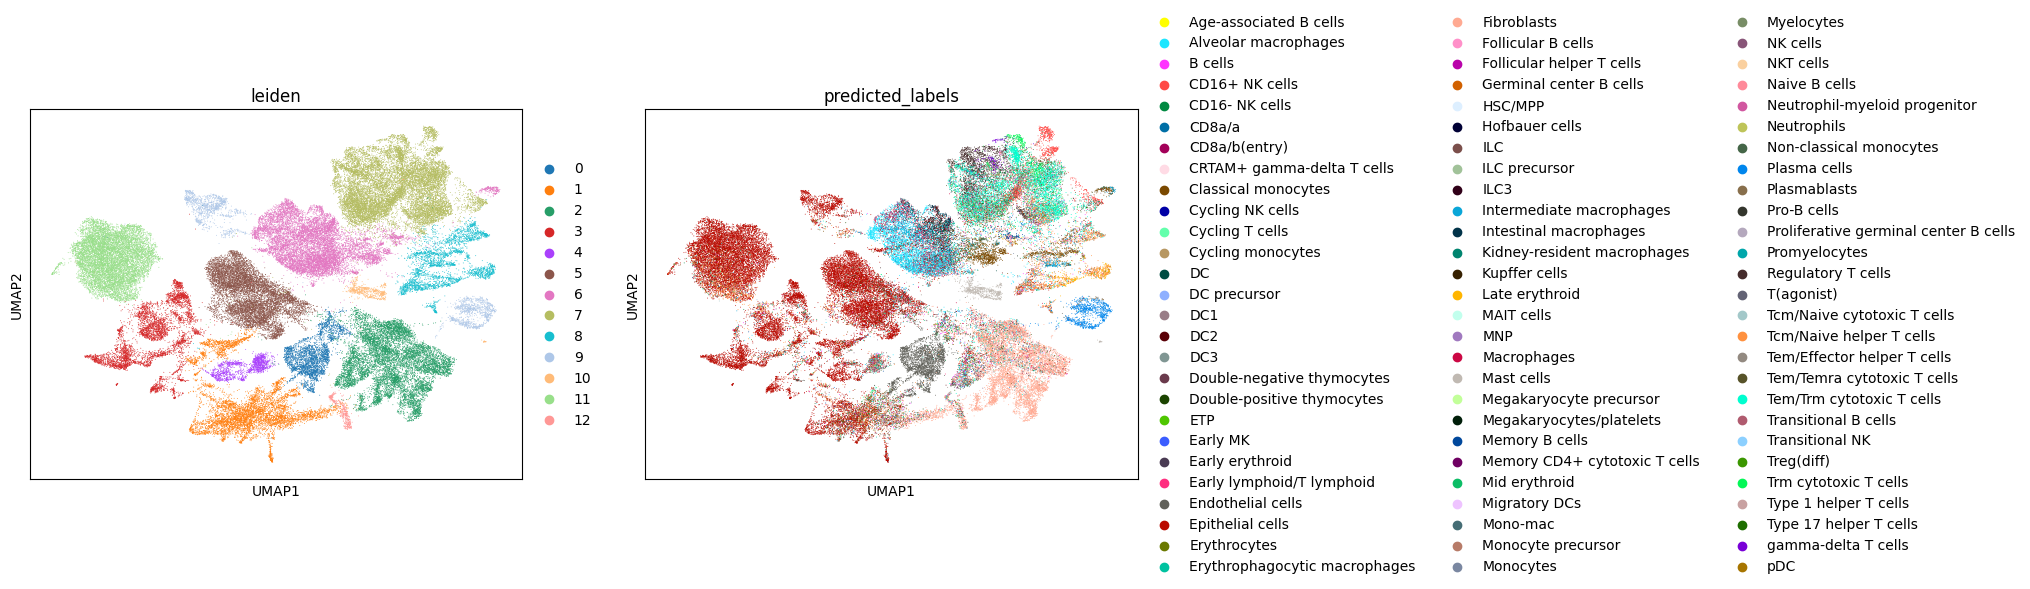

In [20]:
# Plotting the UMAP visualization, coloring cells based on 'leiden' clusters and the predicted cell type labels 
# obtained from the CellTypist model.
sc.pl.umap(adata, color=['leiden', 'predicted_labels'])


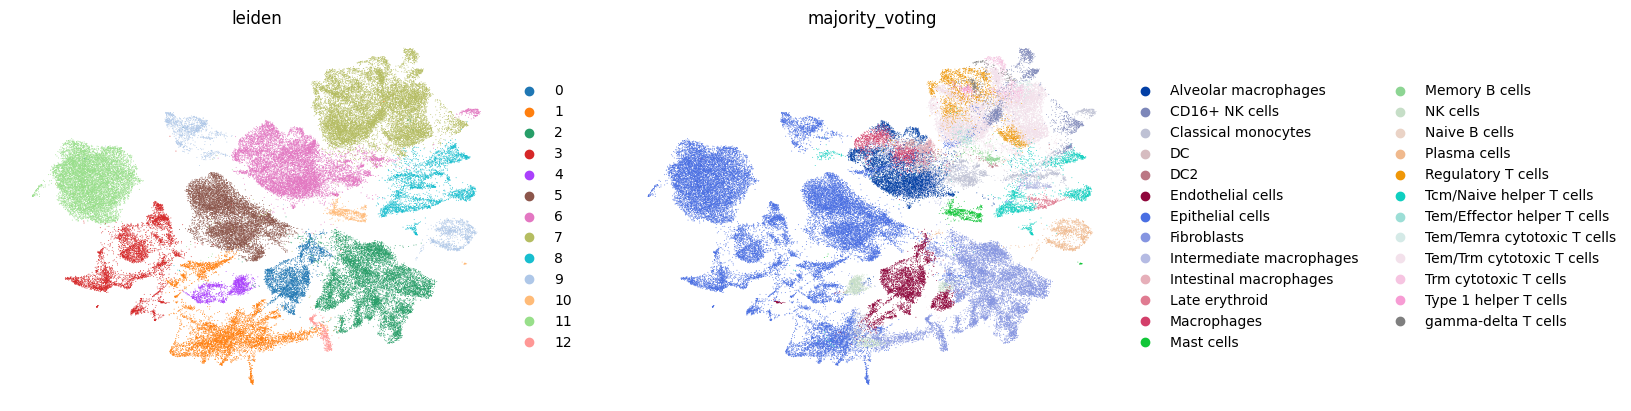

In [21]:
# Plotting the UMAP visualization, coloring cells based on 'leiden' clusters and the majority voting results 
# from the CellTypist model's cell type predictions. The frame around the plot is turned off for cleaner visualization.
sc.pl.umap(adata, color=['leiden', 'majority_voting'], frameon=False)


In [22]:
# Saving the updated AnnData object, which now includes CellTypist cell type annotations, 
# to a new .h5ad file for future analysis or sharing.
adata.write_h5ad(f'{base_data_path}/cell_typist_annotated.h5ad')


## Manual Verification of Cell Type Annotations

In [23]:
# Loading the previously saved AnnData object that contains CellTypist cell type annotations and other analysis results.
adata = sc.read_h5ad(f'{base_data_path}/cell_typist_annotated.h5ad')

# Displaying the contents of the loaded AnnData object for verification.
adata


AnnData object with n_obs × n_vars = 73580 × 26811
    obs: 'Sample', 'doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', '_scvi_batch', '_scvi_labels', 'leiden', 'predicted_labels', 'over_clustering', 'majority_voting', 'conf_score'
    var: 'n_cells'
    uns: 'Sample_colors', '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'leiden_colors', 'log1p', 'majority_voting_colors', 'neighbors', 'over_clustering', 'predicted_labels_colors', 'rank_genes_groups', 'umap'
    obsm: 'X_scVI', 'X_umap'
    layers: 'counts', 'scvi_normalized'
    obsp: 'connectivities', 'distances'

In [24]:
from utilities import plot

In [25]:
# List of epithelial genes for Basal epithelial cells
Basal_epith_genes = ["EPCAM", 'KRT5', 'KRT17', 'VIM', 'ACTA2', "leiden"]

# Call the plot function to print details for these genes
plot(Basal_epith_genes, markers)  # 'KRT14' can be added if needed


Gene: EPCAM
       group  names      scores  logfoldchanges          pvals      pvals_adj
26856      1  EPCAM   46.209446        1.562948   0.000000e+00   0.000000e+00
80451      3  EPCAM   71.705063        2.154252   0.000000e+00   0.000000e+00
107266     4  EPCAM   32.622250        2.083014  1.982080e-174  5.240973e-172
134071     5  EPCAM  122.134605        2.887894   0.000000e+00   0.000000e+00
294979    11  EPCAM   89.325882        2.079928   0.000000e+00   0.000000e+00
-----------------
Gene: KRT5
       group names     scores  logfoldchanges         pvals     pvals_adj
135175     5  KRT5  20.184967        3.266153  1.315931e-88  1.294732e-87
245518     9  KRT5   2.940992        0.668350  3.305194e-03  6.192995e-03
-----------------
Gene: KRT17
       group  names     scores  logfoldchanges          pvals      pvals_adj
80889      3  KRT17  33.871433        1.969810  2.971146e-227  7.176523e-226
107254     4  KRT17  40.284771        3.558367  1.356940e-235  5.964085e-233
134101  

In [27]:
# List of CIN1-associated genes
CIN1_genes = ["EZH2", 'JUN', 'VIM', 'STEAP1', 'SOX4', 'MMP14', 'TIMP1', 'ZEB1', 'ITGB5', 'ITGB1', 'ITGA5',
              'IGFBP4', 'FN1', 'DSC2', 'CXCL1', 'CTNNB1', 'BMP4', 'BCL2L1', 'KIF2A', 'SHH', 'KIF2C', 'leiden']

# Call the plot function to print details for these genes
plot(CIN1_genes, markers)  # 'SHH', 'KIF2B', 'KIF2C' can be modified as needed


Gene: EZH2
       group names     scores  logfoldchanges         pvals     pvals_adj
188559     7  EZH2  16.365286        1.106851  1.042832e-59  4.015422e-59
243282     9  EZH2   5.902141        0.662454  4.133448e-09  1.466092e-08
299585    11  EZH2  10.636176        0.697330  2.654050e-26  8.181872e-26
-----------------
Gene: JUN
       group names     scores  logfoldchanges          pvals      pvals_adj
107262     4   JUN  33.628033        1.636226  1.028297e-183  3.132918e-181
187883     7   JUN  42.934322        1.062330   0.000000e+00   0.000000e+00
268136    10   JUN  23.893513        2.270431   9.248135e-90   1.482079e-88
-----------------
Gene: VIM
       group names      scores  logfoldchanges          pvals      pvals_adj
3          0   VIM   80.459953        2.720602   0.000000e+00   0.000000e+00
53631      2   VIM  176.932556        3.128171   0.000000e+00   0.000000e+00
160883     6   VIM  124.529175        2.531710   0.000000e+00   0.000000e+00
268117    10   VIM   43.3

In [28]:
# List of epithelial genes for Luminal epithelial cells
Luminal_epith_genes = ["EPCAM", 'MUC1', 'KRT18', 'KRT8', 'ESR1', "leiden"]

# Call the plot function to print details for these genes
plot(Luminal_epith_genes, markers)  # 'CDH1' can be added if needed


Gene: EPCAM
       group  names      scores  logfoldchanges          pvals      pvals_adj
26856      1  EPCAM   46.209446        1.562948   0.000000e+00   0.000000e+00
80451      3  EPCAM   71.705063        2.154252   0.000000e+00   0.000000e+00
107266     4  EPCAM   32.622250        2.083014  1.982080e-174  5.240973e-172
134071     5  EPCAM  122.134605        2.887894   0.000000e+00   0.000000e+00
294979    11  EPCAM   89.325882        2.079928   0.000000e+00   0.000000e+00
-----------------
Gene: MUC1
       group names      scores  logfoldchanges          pvals     pvals_adj
26830      1  MUC1   67.250473        2.225483   0.000000e+00  0.000000e+00
80445      3  MUC1   80.120857        2.585596   0.000000e+00  0.000000e+00
108005     4  MUC1    7.981285        0.519371   2.931961e-15  2.523557e-14
135080     5  MUC1   21.461967        0.593870  2.160067e-100  2.383274e-99
294922    11  MUC1  234.192276        4.233427   0.000000e+00  0.000000e+00
-----------------
Gene: KRT18
     

In [30]:
# List of genes for Monocyte-derived macrophages and dendritic cells (MoMac/DC)
momacDC_genes = ["CSF1R", "APOE", "C1QA", "FN1", "CD68", "NAAA", "leiden"]

# Call the plot function to print details for these genes
plot(momacDC_genes, markers)  # 'FCGR1', 'MGL2' can be added if needed


Gene: CSF1R
       group  names     scores  logfoldchanges  pvals  pvals_adj
160969     6  CSF1R  74.492302        6.187206    0.0        0.0
-----------------
Gene: APOE
       group names     scores  logfoldchanges     pvals  pvals_adj
160917     6  APOE  90.916084        4.780113  0.000000   0.000000
323494    12  APOE   3.067823        0.636941  0.002291   0.004422
-----------------
Gene: C1QA
       group names      scores  logfoldchanges  pvals  pvals_adj
160893     6  C1QA  108.879753        6.018776    0.0        0.0
-----------------
Gene: FN1
       group names      scores  logfoldchanges          pvals      pvals_adj
285        0   FN1   24.584461        1.583383  4.646181e-122  1.594991e-120
53647      2   FN1  136.118118        4.904986   0.000000e+00   0.000000e+00
107676     4   FN1   10.023884        0.852012   6.746683e-23   9.725017e-22
162476     6   FN1   15.611250        0.601959   1.736021e-54   8.115862e-54
322286    12   FN1    6.709347        1.084216   6.12528

In [31]:
# List of genes for Neutrophils
Neut_genes = ["CSF3R", "TREM1", "ARG2", "S100A8", "leiden"]

# Call the plot function to print details for these genes
plot(Neut_genes, markers)  # 'LY6G', 'S100A8' can be added if needed


Gene: CSF3R
       group  names     scores  logfoldchanges          pvals      pvals_adj
161247     6  CSF3R  43.497223        2.668683   0.000000e+00   0.000000e+00
214502     8  CSF3R  25.564213        3.284499  4.561961e-131  2.533887e-130
-----------------
Gene: TREM1
       group  names     scores  logfoldchanges         pvals     pvals_adj
160999     6  TREM1  69.632561        4.337081  0.000000e+00  0.000000e+00
214528     8  TREM1  16.024759        1.976930  1.265275e-55  3.871638e-55
-----------------
Gene: ARG2
       group names    scores  logfoldchanges         pvals     pvals_adj
28291      1  ARG2  7.450020        1.443743  1.050435e-13  4.666647e-13
244504     9  ARG2  4.015679        0.956514  6.124506e-05  1.473211e-04
269001    10  ARG2  3.371903        1.999059  7.938773e-04  1.417559e-03
-----------------
Gene: S100A8
       group   names     scores  logfoldchanges          pvals      pvals_adj
161148     6  S100A8  49.738613        3.222203   0.000000e+00   0.00000

In [32]:
# List of genes for Neutrophil subtypes
Neut_sub_genes = ["MMP8", "IFIT1", "ADAM8", "PALD1", "CCL3", "CTSC", "leiden"]

# Call the plot function to print details for these genes
plot(Neut_sub_genes, markers)


Gene: MMP8
       group names    scores  logfoldchanges         pvals     pvals_adj
91700      3  MMP8  2.928135        1.191507  3.424875e-03  5.303166e-03
163236     6  MMP8  9.842484        3.684663  9.182598e-23  2.739148e-22
-----------------
Gene: IFIT1
       group  names     scores  logfoldchanges         pvals     pvals_adj
86139      3  IFIT1   9.954214        0.755006  3.833498e-23  1.240105e-22
163108     6  IFIT1  10.585963        0.623917  4.393394e-26  1.395301e-25
298897    11  IFIT1  12.509259        0.754552  1.122833e-35  3.992079e-35
323783    12  IFIT1   2.713395        0.811006  6.926335e-03  1.233081e-02
-----------------
Gene: ADAM8
       group  names     scores  logfoldchanges          pvals      pvals_adj
161394     6  ADAM8  36.117485        1.691622  2.123658e-271  3.067747e-270
296178    11  ADAM8  26.858925        1.223351  3.676803e-154  3.329239e-153
-----------------
Gene: PALD1
       group  names    scores  logfoldchanges          pvals      pvals_ad

In [33]:
# List of genes for Myeloid-derived dendritic cells (mpDC)
mpDC_genes = ["ZBTB46", "ITGAX", "CCR7", "leiden"]

# Call the plot function to print details for these genes
plot(mpDC_genes, markers)  # 'SIGLECH', 'CLEC9A' can be added if needed


Gene: ZBTB46
       group   names     scores  logfoldchanges         pvals     pvals_adj
1238       0  ZBTB46  10.800447        2.311255  1.072361e-26  8.528942e-26
58595      2  ZBTB46   7.816749        0.979989  5.912495e-15  1.611630e-14
110621     4  ZBTB46   2.775975        0.963863  5.577771e-03  1.111009e-02
164524     6  ZBTB46   4.713181        0.565963  2.463313e-06  4.474822e-06
-----------------
Gene: ITGAX
       group  names     scores  logfoldchanges         pvals     pvals_adj
160960     6  ITGAX  76.667053        4.286568  0.000000e+00  0.000000e+00
214598     8  ITGAX  10.433570        1.216295  4.393934e-25  9.521196e-25
268940    10  ITGAX   3.611526        0.798082  3.293634e-04  6.177810e-04
-----------------
Gene: CCR7
       group names     scores  logfoldchanges         pvals     pvals_adj
188362     7  CCR7  20.227440        2.351971  8.926107e-90  4.208156e-89
214606     8  CCR7   9.790088        2.087970  2.571079e-22  5.359863e-22
-----------------


In [35]:
# List of genes for B cells
B_cell_genes = ["CD74", "CD209A", "CD19", "leiden"]

# Call the plot function to print details for these genes
plot(B_cell_genes, markers)  # 'CD209A', 'CD19' can be added if needed


Gene: CD74
       group names      scores  logfoldchanges         pvals     pvals_adj
692        0  CD74   15.557744        0.747768  1.140638e-52  1.615512e-51
107332     4  CD74   20.693399        1.175654  1.439728e-83  1.317425e-81
160870     6  CD74  199.071609        4.392920  0.000000e+00  0.000000e+00
-----------------
Gene: CD209A
Empty DataFrame
Columns: [group, names, scores, logfoldchanges, pvals, pvals_adj]
Index: []
-----------------
Gene: CD19
       group names    scores  logfoldchanges         pvals     pvals_adj
163973     6  CD19  6.457506        2.475964  1.108569e-10  2.416017e-10
244227     9  CD19  4.364675        2.302842  1.333276e-05  3.458441e-05
-----------------


In [37]:
# List of genes for Macrophages
Macrophage_genes = ["CD68", "NAAA", 'ITGAM', "MRC1", "ITGAE", "CLEC4A2", "LY6C1", "ARG1", "leiden"]

# Call the plot function to print details for these genes
plot(Macrophage_genes, markers)  # 'Ly6c1', 'Arg', 'Itgae' (M2 markers) can be added if needed


Gene: CD68
       group names      scores  logfoldchanges  pvals  pvals_adj
160881     6  CD68  131.735031         4.59831    0.0        0.0
-----------------
Gene: NAAA
       group names     scores  logfoldchanges          pvals      pvals_adj
57337      2  NAAA  10.959494        0.592347   8.132344e-28   2.942460e-27
161656     6  NAAA  28.464167        1.532287  1.208287e-172  1.186644e-171
-----------------
Gene: ITGAM
       group  names     scores  logfoldchanges         pvals  pvals_adj
161063     6  ITGAM  59.715439        4.205395  0.000000e+00   0.000000
268671    10  ITGAM   4.966077        1.312923  8.880773e-07   0.000002
-----------------
Gene: MRC1
       group names    scores  logfoldchanges  pvals  pvals_adj
160926     6  MRC1  88.29319        5.857359    0.0        0.0
-----------------
Gene: ITGAE
       group  names     scores  logfoldchanges          pvals      pvals_adj
188106     7  ITGAE  28.640686        1.539719  8.562017e-176  6.060091e-175
-----------------

In [39]:
# List of genes for Proliferation-related markers
Prolifer_genes = ['CDK1', 'MKI67', 'E2F1', 'CCNE1', 'MYBL2', 'BUB1', 'CENPF',
                  'CCND1', 'CCNB1', "leiden"]

# Call the plot function to print details for these genes
plot(Prolifer_genes, markers)  # 'MKI67', 'E2F1', 'MYBL2', 'BUB1', 'PLK1', 'CCNE1' can be added if needed


Gene: CDK1
       group names     scores  logfoldchanges         pvals     pvals_adj
135997     5  CDK1  12.414433        1.312232  4.092923e-35  1.965527e-34
242024     9  CDK1   9.413502        1.664527  1.185555e-20  7.788759e-20
301509    11  CDK1   6.769576        0.659738  1.354163e-11  2.998304e-11
-----------------
Gene: MKI67
       group  names     scores  logfoldchanges         pvals     pvals_adj
135906     5  MKI67  12.935846        1.043509  5.767777e-38  2.923801e-37
242117     9  MKI67   9.040796        1.250720  3.340529e-19  2.069384e-18
297743    11  MKI67  16.750364        1.292970  3.313975e-62  1.571471e-61
-----------------
Gene: E2F1
       group names    scores  logfoldchanges         pvals     pvals_adj
87381      3  E2F1  7.875334        1.591357  4.121792e-15  1.101130e-14
243382     9  E2F1  5.726709        1.398021  1.163974e-08  3.982048e-08
304149    11  E2F1  3.293427        0.549460  9.926789e-04  1.519885e-03
-----------------
Gene: CCNE1
       group

In [40]:
# List of genes for Fibroblasts
Fibro_genes = ['FAP', 'VIM', 'VTN', 'PDGFRB', 'COL6A2', 'COL1A2', 'PRRX1', 'P4HA1', 'TNFRSF1B', "leiden"]

# Call the plot function to print details for these genes
plot(Fibro_genes, markers)  # 'VTN' can be added if needed


Gene: FAP
      group names     scores  logfoldchanges         pvals     pvals_adj
983       0   FAP  12.552387        1.188722  2.810745e-35  2.801445e-34
53735     2   FAP  79.104706        5.394433  0.000000e+00  0.000000e+00
-----------------
Gene: VIM
       group names      scores  logfoldchanges          pvals      pvals_adj
3          0   VIM   80.459953        2.720602   0.000000e+00   0.000000e+00
53631      2   VIM  176.932556        3.128171   0.000000e+00   0.000000e+00
160883     6   VIM  124.529175        2.531710   0.000000e+00   0.000000e+00
268117    10   VIM   43.361252        2.711016  4.449784e-192  1.861204e-190
321732    12   VIM   86.285126        4.157690  1.223471e-287  1.470963e-285
-----------------
Gene: VTN
      group names     scores  logfoldchanges         pvals     pvals_adj
27646     1   VTN  11.067086        4.462713  3.276676e-28  2.372426e-27
-----------------
Gene: PDGFRB
      group   names     scores  logfoldchanges  pvals  pvals_adj
53692     2

In [42]:
# List of genes for PDAC (Pancreatic Ductal Adenocarcinoma) epithelial cells
PDAC_epith_genes = ["EPCAM", 'KRT7', 'KRT17', 'MUC1', 'TFF2', 'TFF3', 'OLFM4', 'TFF1', 'LGALS4', 
                    'ENO1', 'HDGF', 'LCN2', "leiden"]

# Call the plot function to print details for these genes
plot(PDAC_epith_genes, markers)


Gene: EPCAM
       group  names      scores  logfoldchanges          pvals      pvals_adj
26856      1  EPCAM   46.209446        1.562948   0.000000e+00   0.000000e+00
80451      3  EPCAM   71.705063        2.154252   0.000000e+00   0.000000e+00
107266     4  EPCAM   32.622250        2.083014  1.982080e-174  5.240973e-172
134071     5  EPCAM  122.134605        2.887894   0.000000e+00   0.000000e+00
294979    11  EPCAM   89.325882        2.079928   0.000000e+00   0.000000e+00
-----------------
Gene: KRT7
       group names     scores  logfoldchanges          pvals      pvals_adj
27004      1  KRT7  23.930868        0.994288  7.138904e-122  1.826347e-120
80461      3  KRT7  62.551594        2.541813   0.000000e+00   0.000000e+00
107267     4  KRT7  32.364212        2.477848  7.136700e-172  1.857690e-169
134102     5  KRT7  89.857658        2.838576   0.000000e+00   0.000000e+00
241702     9  KRT7  11.557664        0.763642   4.782654e-30   4.329093e-29
295911    11  KRT7  30.470520      

In [43]:
# List of additional PDAC epithelial genes (from PDAC ST marker paper)
PDAC_epith_genes2 = ['S100A6', 'TFF1', 'FCGBP', 'LGALS4', 'TFF3', 'TSPAN8', 'HSP90AA1', 'VNN1', "leiden"]

# Call the plot function to print details for these genes and markers
plot(PDAC_epith_genes2, markers)


Gene: S100A6
       group   names      scores  logfoldchanges          pvals      pvals_adj
26900      1  S100A6   33.183571        0.737038  1.057598e-227  5.705285e-226
80439      3  S100A6   89.496590        2.107531   0.000000e+00   0.000000e+00
107256     4  S100A6   39.002010        1.306085  3.049558e-232  1.277527e-229
134067     5  S100A6  133.245499        2.120086   0.000000e+00   0.000000e+00
294931    11  S100A6  139.551849        2.016249   0.000000e+00   0.000000e+00
321756    12  S100A6   23.428234        1.220648   5.256156e-80   1.269575e-78
-----------------
Gene: TFF1
       group names      scores  logfoldchanges         pvals     pvals_adj
26834      1  TFF1   63.935436        2.563238  0.000000e+00  0.000000e+00
82205      3  TFF1   21.396872        0.982731  8.656384e-98  7.756895e-97
294921    11  TFF1  247.177048        6.454982  0.000000e+00  0.000000e+00
-----------------
Gene: FCGBP
       group  names     scores  logfoldchanges         pvals     pvals_adj


In [44]:
# List of PDAC epithelial genes
PDAC_epith_genes = ['KDF1', 'FA2H', 'CDHR5', 'SYTL1', 'LEMD1', 'NECTIN4', 'ADAM8', 'TMPRSS3', 'EVPL', "leiden"]

# Call the plot function to print details for these genes and markers
plot(PDAC_epith_genes, markers)


Gene: KDF1
       group names     scores  logfoldchanges         pvals     pvals_adj
28450      1  KDF1   6.936147        1.155322  4.406013e-12  1.805711e-11
82752      3  KDF1  18.852102        2.348991  1.120575e-76  8.065431e-76
110448     4  KDF1   2.943534        0.899414  3.298803e-03  6.886570e-03
137355     5  KDF1   6.181326        0.824888  6.611999e-10  1.598794e-09
242524     9  KDF1   7.669893        1.356852  2.564009e-14  1.259041e-13
301111    11  KDF1   7.454343        0.921541  9.702648e-14  2.288937e-13
-----------------
Gene: FA2H
       group names     scores  logfoldchanges          pvals      pvals_adj
82503      3  FA2H  19.924725        1.146894   2.551725e-85   2.010411e-84
134644     5  FA2H  30.417910        1.775301  6.765204e-194  1.487956e-192
243091     9  FA2H   6.316182        0.572846   3.221145e-10   1.236748e-09
295286    11  FA2H  46.000301        2.560822   0.000000e+00   0.000000e+00
-----------------
Gene: CDHR5
       group  names     scores  

In [45]:
# List of endothelial cell genes
Endo = ['CD93', 'VWF', 'KDR', 'EGFL7', 'FLT1', 'EMCN', "leiden"]

# Call the plot function to print details for these genes and markers
plot(Endo, markers)


Gene: CD93
       group names     scores  logfoldchanges  pvals  pvals_adj
7          0  CD93  65.706619        5.224608    0.0        0.0
161259     6  CD93  43.168720        2.354739    0.0        0.0
-----------------
Gene: VWF
       group names     scores  logfoldchanges     pvals  pvals_adj
8          0   VWF  65.386284        7.469020  0.000000   0.000000
109259     4   VWF   4.497406        0.888493  0.000007   0.000025
-----------------
Gene: KDR
       group names     scores  logfoldchanges          pvals      pvals_adj
163        0   KDR  31.021149        7.207736  9.164436e-183  5.216724e-181
109769     4   KDR   3.736418        1.236285   1.942385e-04   5.134308e-04
-----------------
Gene: EGFL7
       group  names     scores  logfoldchanges         pvals     pvals_adj
13         0  EGFL7  59.035717        5.857358  0.000000e+00  0.000000e+00
107867     4  EGFL7   8.594084        1.463636  2.228771e-17  2.279007e-16
-----------------
Gene: FLT1
       group names     score

In [47]:
# List of Schwann cell genes
Schwann = ['SOX10', 'NRXN1', 'S100B', 'MYOT', 'FOXD3', 'GFRA3', 'DRAXIN', 'PLP1', 'CRLF1', 'KIRREL3', "leiden"]

# Call the plot function to print details for these genes and markers
plot(Schwann, markers)


Gene: SOX10
       group  names     scores  logfoldchanges         pvals     pvals_adj
321827    12  SOX10  15.018229       10.951553  2.867903e-41  3.396261e-40
-----------------
Gene: NRXN1
       group  names     scores  logfoldchanges          pvals      pvals_adj
321743    12  NRXN1  33.206188       11.195106  1.258123e-120  4.711108e-119
-----------------
Gene: S100B
       group  names     scores  logfoldchanges          pvals      pvals_adj
108488     4  S100B   6.150818        1.426305   1.006955e-09   5.248342e-09
161653     6  S100B  28.500729        2.607402  9.152087e-173  8.998042e-172
321734    12  S100B  44.664394        8.286644  1.786464e-163  9.855327e-162
-----------------
Gene: MYOT
       group names     scores  logfoldchanges         pvals     pvals_adj
321814    12  MYOT  15.991958       10.224364  1.733479e-45  2.258324e-44
-----------------
Gene: FOXD3
       group  names     scores  logfoldchanges         pvals     pvals_adj
321929    12  FOXD3  11.345751    

In [48]:
# List of stellate cell genes
Stellate = ['HRH2', 'ITGB3', 'PLAUR', 'NRIP2', 'SSTR2', 'KCNMB1', 'ENPEP', 'FHL5', 'TRPC6', 'AVPR1A', 
            'MYH11', 'HIGD1B', "leiden"]

# Call the plot function to print details for these genes and markers
plot(Stellate, markers)


Gene: HRH2
       group names     scores  logfoldchanges          pvals      pvals_adj
57301      2  HRH2  11.054495        1.290379   2.973599e-28   1.084549e-27
161781     6  HRH2  25.840805        2.943591  4.280793e-143  3.627445e-142
-----------------
Gene: ITGB3
       group  names     scores  logfoldchanges         pvals     pvals_adj
850        0  ITGB3  13.685447        3.131889  2.242608e-41  2.595018e-40
59287      2  ITGB3   6.406854        0.963023  1.546666e-10  3.671330e-10
163487     6  ITGB3   8.608835        1.242260  8.276940e-18  2.211170e-17
-----------------
Gene: PLAUR
       group  names     scores  logfoldchanges          pvals      pvals_adj
134470     5  PLAUR  36.583282        1.072614  1.274187e-276  4.379771e-275
160908     6  PLAUR  94.978783        2.707201   0.000000e+00   0.000000e+00
214629     8  PLAUR   8.745066        0.591936   3.517302e-18   6.879871e-18
-----------------
Gene: NRIP2
      group  names     scores  logfoldchanges         pvals    

In [49]:
# List of genes for a PDAC subtype (subtype 1)
PDAC_sub1 = ['FTX', 'TJP2', "leiden"]

# Call the plot function to print details for these genes and markers
plot(PDAC_sub1, markers)  # 'ZBED6' can be added if needed


Gene: FTX
       group names     scores  logfoldchanges         pvals     pvals_adj
55486      2   FTX  19.607912        0.597962  2.661021e-84  1.802998e-83
295261    11   FTX  47.258163        1.426765  0.000000e+00  0.000000e+00
-----------------
Gene: TJP2
       group names     scores  logfoldchanges          pvals      pvals_adj
80879      3  TJP2  33.982712        1.421763  1.776870e-229  4.374625e-228
108652     4  TJP2   5.721604        0.533792   1.288008e-08   5.996317e-08
134461     5  TJP2  36.957947        1.451275  5.177651e-280  1.807526e-278
295136    11  TJP2  57.109005        2.031354   0.000000e+00   0.000000e+00
-----------------


In [50]:
# List of genes for the Classical PDAC subtype
Classical = ['BTNL8', 'FAM3D', 'PRR15L', 'AGR3', 'CTSE', 'LYZ', 'TFF2', 'TFF1', 'ANXA10', 'LGALS4', 'PLA2G10', 
             'CEACAM6', 'VSIG2', 'TSPAN8', 'ST6GALNAC1', 'AGR2', 'TFF3', 'CYP3A7', 'MYO1A', 'CLRN3', 'KRT20', 
             'CDH17', 'SPINK4', 'REG4', "leiden"]

# Call the plot function to print details for these genes and markers
plot(Classical, markers)



Gene: BTNL8
       group  names    scores  logfoldchanges  pvals  pvals_adj
295138    11  BTNL8  56.93565        5.170242    0.0        0.0
-----------------
Gene: FAM3D
       group  names     scores  logfoldchanges          pvals      pvals_adj
27032      1  FAM3D  22.617729        2.105033  3.778053e-109  8.635413e-108
80657      3  FAM3D  40.997532        3.351177   0.000000e+00   0.000000e+00
301106    11  FAM3D   7.462284        0.534426   9.098957e-14   2.148412e-13
-----------------
Gene: PRR15L
       group   names     scores  logfoldchanges          pvals      pvals_adj
27211      1  PRR15L  16.876596        1.320767   1.270597e-62   1.743396e-61
80752      3  PRR15L  37.406498        2.430268  1.254042e-270  3.833766e-269
107532     4  PRR15L  12.059772        1.758893   6.522161e-32   1.445171e-30
296099    11  PRR15L  27.626947        1.577145  1.878569e-162  1.780357e-161
-----------------
Gene: AGR3
       group names     scores  logfoldchanges         pvals     pvals_ad

In [51]:
# List of genes for the Basal PDAC subtype
Basal = ['PLAUR', 'VGLL1', 'UCA1', 'S100A2', 'LY6D', 'SPRR3', 'SPRR1B', 'LEMD1', 'KRT15', 'CTSV', 'DHRS9', 'AREG', 
         'CST6', 'SERPINB3', 'KRT6A', 'SERPINB4', 'FAM83A', 'SCEL', 'FGFBP1', 'KRT7', 'KRT17', 'GPR87', 'TNS4', 
         'SLC2A1', 'ANXA8L1', "leiden"]

# Call the plot function to print details for these genes and markers
plot(Basal, markers)


Gene: PLAUR
       group  names     scores  logfoldchanges          pvals      pvals_adj
134470     5  PLAUR  36.583282        1.072614  1.274187e-276  4.379771e-275
160908     6  PLAUR  94.978783        2.707201   0.000000e+00   0.000000e+00
214629     8  PLAUR   8.745066        0.591936   3.517302e-18   6.879871e-18
-----------------
Gene: VGLL1
       group  names     scores  logfoldchanges         pvals     pvals_adj
83423      3  VGLL1  16.468578        3.591147  2.370649e-59  1.376044e-58
107747     4  VGLL1   9.332727        3.866739  4.034293e-20  5.030857e-19
137697     5  VGLL1   5.189370        1.132839  2.154230e-07  4.576267e-07
-----------------
Gene: UCA1
       group names     scores  logfoldchanges          pvals      pvals_adj
80732      3  UCA1  38.091583        4.457840  5.097049e-278  1.602075e-276
107508     4  UCA1  12.698779        2.685381   5.159914e-35   1.283325e-33
241441     9  UCA1  15.321241        2.726391   2.395873e-50   3.506318e-49
-----------------

## Gene Set Scoring in Single-Cell RNA-seq Data Using Scanpy

In [52]:
# Importing the Matplotlib library for plotting and visualizing data.
import matplotlib.pyplot as plt


In [53]:
# Defining a list of unique Basal genes of interest using a set to remove duplicates.
gene_list = list(set(['PLAUR', 'VGLL1', 'UCA1', 'S100A2', 'LY6D', 'SPRR3', 'SPRR1B', 'LEMD1', 'KRT15', 'CTSV', 
                      'DHRS9', 'AREG', 'CST6', 'SERPINB3', 'KRT6A', 'SERPINB4', 'FAM83A', 'SCEL', 'FGFBP1', 
                      'KRT7', 'KRT17', 'GPR87', 'TNS4', 'SLC2A1', 'ANXA8L1']))


In [54]:
# Filtering the gene list to include only those genes present in the 'markers' DataFrame.
gene_list_filtered = [gene for gene in gene_list if gene in markers['names'].values]

# Printing the filtered gene list.
print(gene_list_filtered)


['SLC2A1', 'S100A2', 'UCA1', 'AREG', 'ANXA8L1', 'LY6D', 'FAM83A', 'TNS4', 'SERPINB4', 'CST6', 'LEMD1', 'KRT6A', 'CTSV', 'FGFBP1', 'SPRR3', 'KRT17', 'SPRR1B', 'VGLL1', 'DHRS9', 'PLAUR', 'SCEL', 'SERPINB3', 'KRT7', 'KRT15', 'GPR87']


In [55]:
# Calculating the gene set score for the filtered list of genes of interest (Basal genes) against the entire gene pool.
# The score is stored in 'adata.obs' under the name 'score_sig'.
sc.tl.score_genes(adata, gene_list=gene_list_filtered, score_name='score_sig')


In [56]:
# Checking the 'obs' attribute of the AnnData object to see the newly added column with the calculated gene set score ('score_sig').
adata.obs


,Sample,doublet,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes,_scvi_batch,_scvi_labels,leiden,predicted_labels,over_clustering,majority_voting,conf_score,score_sig
AAACCCACAACATACC-1,Treated,False,733,1154.0,169.0,14.644713,124.0,10.745234,733,0,0,0,Type 17 helper T cells,252,Endothelial cells,0.515320,-0.118698
AAACCCACATCTATCT-1,Treated,False,578,928.0,120.0,12.931034,142.0,15.301723,578,0,0,0,Follicular helper T cells,108,Endothelial cells,0.001537,-0.077744
AAACCCACATGATGCT-1,Treated,False,4646,20165.0,1110.0,5.504587,1974.0,9.789239,4646,0,0,2,Fibroblasts,107,Fibroblasts,1.000000,-0.211553
AAACCCAGTATCGTAC-1,Treated,False,677,1050.0,129.0,12.285714,106.0,10.095238,677,0,0,0,Endothelial cells,108,Endothelial cells,0.371935,-0.104166
AAACCCAGTCACCCTT-1,Treated,False,845,1466.0,217.0,14.802183,137.0,9.345157,845,0,0,0,NK cells,108,Endothelial cells,0.008593,0.042900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTGTTCCACGG-1,Untreated,False,1671,3575.0,95.0,2.657343,477.0,13.342658,1671,0,0,7,CD16+ NK cells,109,CD16+ NK cells,0.999999,-0.069141
TTTGTTGGTACCCGCA-1,Untreated,False,3727,14103.0,1531.0,10.855846,2064.0,14.635184,3727,0,0,3,Epithelial cells,60,Epithelial cells,0.998764,0.410204
TTTGTTGGTCGCATGC-1,Untreated,False,1750,3641.0,165.0,4.531722,404.0,11.095853,1750,0,0,7,CD16+ NK cells,109,CD16+ NK cells,0.999907,-0.096315
TTTGTTGGTTCTCACC-1,Untreated,False,545,709.0,25.0,3.526093,73.0,10.296192,545,0,0,3,NK cells,227,Epithelial cells,0.546331,0.268799


In [57]:
# Extracting UMAP coordinates from 'obsm' for plotting
umap_coords = adata.obsm['X_umap']

# Extracting the gene set scores ('score_sig') from 'obs' for visualization
scores = adata.obs['score_sig']


<Figure size 1000x800 with 0 Axes>

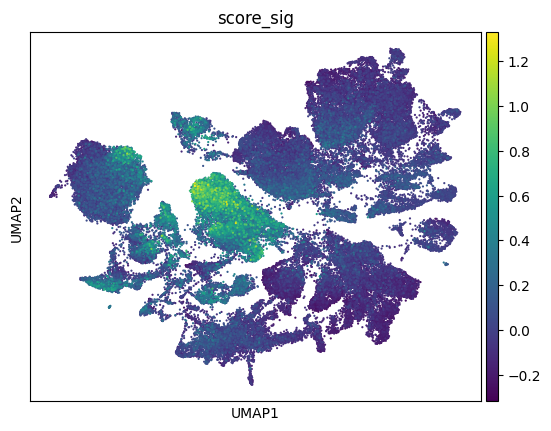

In [58]:
# Creating a figure for the plot with specified dimensions
plt.figure(figsize=(10, 8))

# Plotting the UMAP visualization, coloring cells based on the gene set score ('score_sig') using the 'viridis' colormap
# The 'size' argument controls the size of the points on the plot
sc.pl.umap(adata, color='score_sig', cmap='viridis', size=10)


In [59]:
# Dictionary mapping cluster numbers to cell type labels for easier interpretation of Leiden clusters
cell_type = {
    "0": "G0.T cells/NK",
    "1": "G1.Macrophage_DC1",
    "2": "G2.Epithelial_pro_1",
    "3": "G3.Fibroblast",
    "4": "G4.Epithelial_pro_2",
    "5": "G5.Epithelial_3",
    "6": "G6.Epithelial_4",
    "7": "G7.Endothelial",
    "8": "G8.Epithelial_5",
    "9": "G9.B_cells_1",
    "10": "G10.Epithelial_normal",
    "11": "G11.B_cells_2"
}


In [60]:
# Mapping the Leiden cluster labels to cell types using the predefined cell_type dictionary
# and adding the new 'cell_type' column to the AnnData object.
adata.obs['cell_type'] = adata.obs.leiden.map(cell_type)


... storing 'cell_type' as categorical


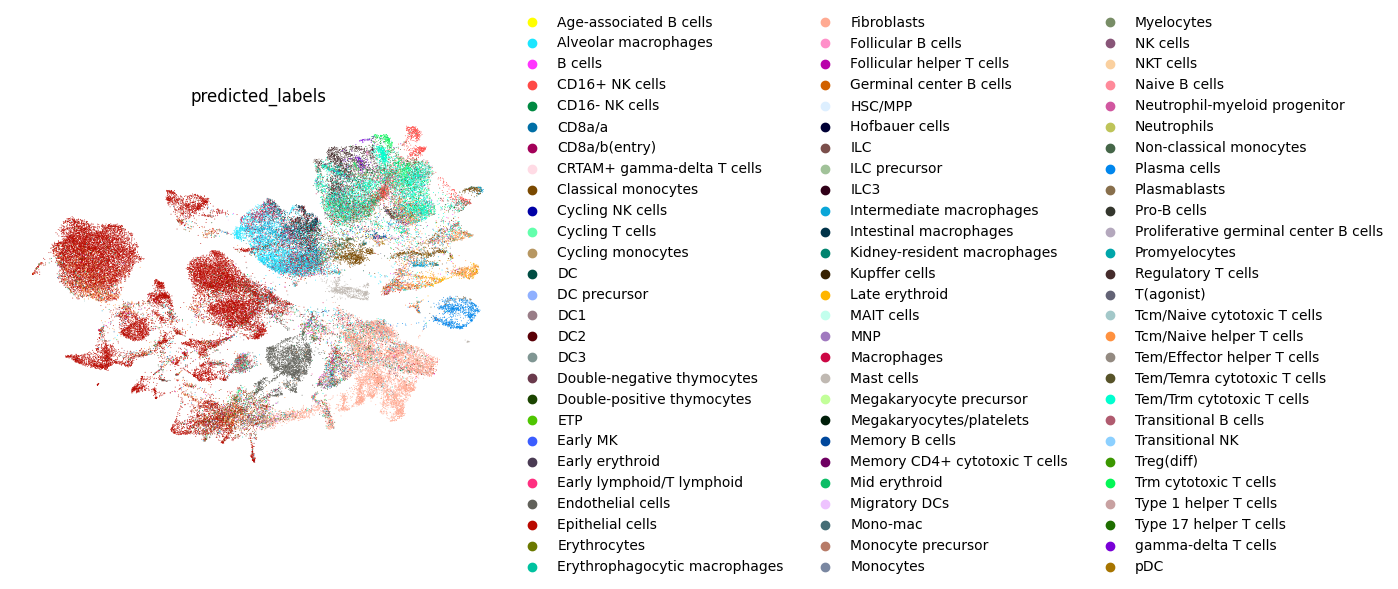

In [61]:
# Plotting the UMAP visualization, coloring cells based on the predicted labels from CellTypist.
# The plot uses the 'scvi_normalized' data layer, and the frame around the plot is turned off for a cleaner look.
sc.pl.umap(adata, color=['predicted_labels'], frameon=False, layer="scvi_normalized")


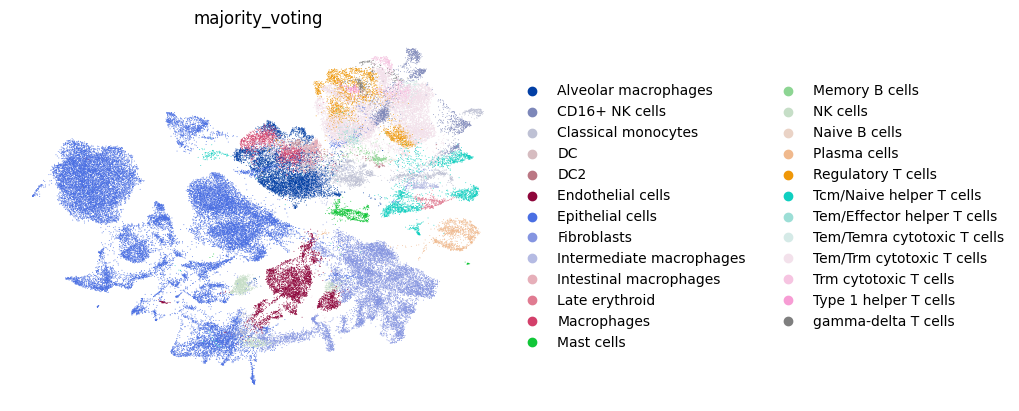

In [63]:
# Plotting the UMAP visualization, coloring cells based on the majority voting results from CellTypist.
# The plot uses the 'scvi_normalized' data layer, and the frame around the plot is turned off for a cleaner appearance.
sc.pl.umap(adata, color=['majority_voting'], frameon=False, layer="scvi_normalized")


In [64]:
# Saving the updated AnnData object, which includes CellTypist annotations, to an .h5ad file for future use.
adata.write_h5ad(f'{base_data_path}/cell_typist_annotated.h5ad')
